論文  
https://arxiv.org/abs/2112.10752<br>
<br>
GitHub  
https://github.com/CompVis/stable-diffusion<br>
<br>
<a href="https://colab.research.google.com/github/kaz12tech/ai_demos/blob/master/StableDiffusion_inpainting_demo.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 環境セットアップ

## GPU確認

In [ ]:
!nvidia-smi

## GitHubからコード取得

In [ ]:
%cd /content

!git clone https://github.com/huggingface/diffusers.git
!sed -E -i "s/sample\(generator=generator\)/sample\(\)/" /content/diffusers/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_inpaint.py

## ライブラリのインストール

In [ ]:
%cd /content

!pip install diffusers transformers scipy ftfy

## Access Token取得
[Huggingface](https://huggingface.co/)にSign Up後メール認証<br>
その後、[CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)にアクセスし以下に同意<br>
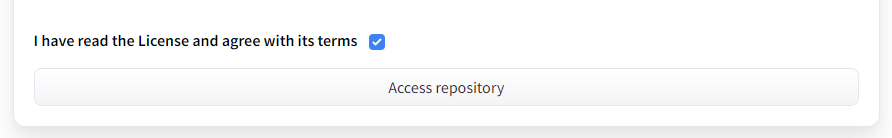
<br><br>
その後、Settings → Access Token
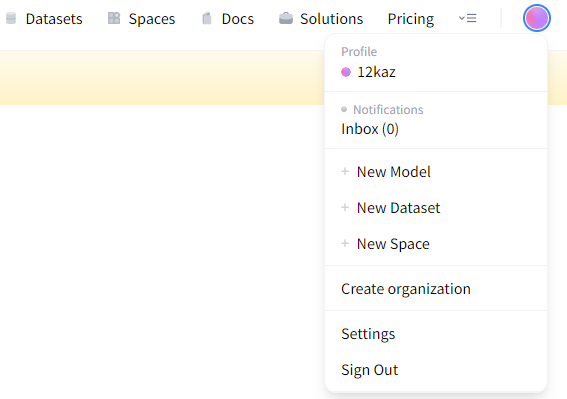


In [ ]:
access_tokens="ここに取得したAccess Tokenを記載" # @param {type:"string"}

## ライブラリのインポート

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

import torch
from torch import autocast

%cd /content/diffusers

from src.diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint import StableDiffusionInpaintPipeline

In [ ]:
%cd /content/diffusers
filename = 'test_01.jpg'

!rm -rf {filename}

!wget -c https://www.pakutaso.com/shared/img/thumb/SAYA160312500I9A3721_TP_V4.jpg \
      -O {filename}

# Inpainting

## load model

In [ ]:
%cd /content/diffusers

device = "cuda"
pipe = StableDiffusionInpaintingPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=access_tokens
).to(device)

## set image

In [ ]:
img_w, img_h = 768, 512

In [ ]:
%cd /content/diffusers

init_image = Image.open(filename)
if '.png' in filename:
  init_image = init_image.convert('RGB')
init_image = init_image.resize((img_w, img_h))

plt.imshow(init_image)
plt.axis('off')
plt.show()

## create mask

In [ ]:
x1 = 400  #@param {type:"integer"}
y1 = 0    #@param {type:"integer"}
x2 = 650  #@param {type:"integer"}
y2 = 300  #@param {type:"integer"}

In [ ]:
%cd /content/diffusers

temp = Image.open(filename)
if '.png' in filename:
  temp = temp.convert('RGB')
mask_img = temp.resize((img_w, img_h))
draw = ImageDraw.Draw(mask_img)

# 矩形の設定
rectcolor = (255, 0, 0)
linewidth = 4
draw.rectangle(
    [(x1, y1), (x2, y2)], # 左上x,y 右下x,y
    outline=rectcolor, width=linewidth,
    )
mask_img

In [ ]:
# mask画像生成

# 一度すべて黒く塗りつぶし
rectcolor = (0, 0, 0)
draw.rectangle(
    [(0, 0), (img_w, img_h)],
    outline=rectcolor, fill=(0, 0, 0)
    )
# 先ほど設定した矩形箇所白く塗りつぶし
rectcolor = (255, 255, 255)
draw.rectangle(
   [(x1, y1), (x2, y2)],
    outline=rectcolor, fill=(255, 255, 255)
    )
mask_img

## set prompt

In [ ]:
prompt = "ganesha face" #@param {type:"string"}

In [ ]:
generator = torch.Generator(device).manual_seed(12)

with autocast("cuda"):
  images = pipe(
      prompt=prompt,
      init_image=init_image,
      mask_image=mask_img,
      strength=0.75,
      guidance_scale=7.5,
      generator=generator,
  )["sample"]

images[0].save("inpainting_01.png")

In [ ]:
plt.imshow(plt.imread("inpainting_01.png"))

plt.axis('off')
plt.show()